## Disclaimer:
The fine-tuning for this model has been run on Colab's L4 GPU and will not run on the T4 GPU due to memory constraints.

# Setup

In [ ]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True \
                   --to notebook --inplace "4_Strategic_Positioning_Classification_Model.ipynb"

[NbConvertApp] Converting notebook 4_Strategic_Positioning_Classification_Model.ipynb to notebook
[NbConvertApp] Writing 190475 bytes to 4_Strategic_Positioning_Classification_Model.ipynb


In [1]:
# Packages

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import torch
import numpy as np
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer,
    default_data_collator, EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model, TaskType
import gc

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')
import random

import os
from google.colab import files


import pandas as pd

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"
os.environ["TRANSFORMERS_VERBOSITY"] = "error"

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# LOADING THE MODEL

model_name = "Qwen/Qwen3-0.6B"


tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
  tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels = 2, #for binary classification
    torch_dtype = "auto",
    device_map = "auto" if torch.cuda.is_available() else None,
)


print(f"Model parameters: {base_model.num_parameters():,}")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Some weights of Qwen3ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen3-0.6B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 596,051,968


# Baseline Predictions and Evaluation

In [3]:
#Creating a prompt

max_len = 2048

def build_prompt(text, sentiment, tokenizer, max_len):
  prefix = (
      'You are an expert classifier for corporate risk communications.\n'
      'Classify the following environmental risk sentences from a 10-K filing.\n'
      'Labels:\n\n'
      '0=acknowledging (states the risk descriptively without stressing or minimizing)\n'
      '1=actively managing (emphasizes concrete actions, commitments, or leadership in addressing the risk)\n\n'
      'Output only one number. Do not ouput anything else.\n'
      f'Sentiment: "{sentiment}" (context only)\n\n'
      'Sentences:\n'
  )

  options = "\n\nFinal Answer: [0|1]"

  prefix_ids = tokenizer(prefix, add_special_tokens = False)["input_ids"]
  body_ids = tokenizer(text, add_special_tokens = False)["input_ids"]
  options_ids = tokenizer(options, add_special_tokens=False)["input_ids"]

  remaining = max_len - len(prefix_ids) - len(options_ids)
  if remaining <= 0:
    raise ValueError("prefix is longer than max length")

  if len(body_ids) > remaining:
    body_ids = body_ids[:remaining-1]
    body_ids.extend(tokenizer("...", add_special_tokens = False)["input_ids"])

  input_ids = prefix_ids + body_ids + options_ids

  return tokenizer.decode(input_ids, skip_special_tokens=True)



In [ ]:
#Generating baseline annotations for the annotations dataset:
df = pd.read_excel("df_env_risk_tone_grouped.xlsx")

cols_tokeep = ["cik", "FiscalYearEnd", "full_text", "full_sentiment"]

df_to_annotate = df.drop(columns = [col for col in df.columns if col not in cols_tokeep])


for i, row in tqdm(df_to_annotate.iterrows(), desc = "Generating baseline Communication Strategy predictions", total = len(df_to_annotate)):
  prompt = build_prompt(row["full_text"], row["full_sentiment"], tokenizer, max_len)

  inputs = tokenizer(
      prompt,
      return_tensors = "pt",
      truncation = True,
      padding = "max_length",
      max_length = max_len
  )

  inputs = {k: v.to(base_model.device) for k,v in inputs.items()}

  base_model.eval()

  with torch.no_grad():
    outputs = base_model(**inputs)
    logits = outputs.logits

  pred_class = torch.argmax(logits, dim=-1).item()

  df_to_annotate.at[i, "risk_communication"] = pred_class

df_to_annotate = df_to_annotate.sample(n = 1000, random_state = 42)
display(df_to_annotate.head())

df_to_annotate.to_excel("risk_comm_annotations.xlsx", index = False)


Generating baseline Communication Strategy predictions:   0%|          | 0/2577 [00:00<?, ?it/s]

,cik,FiscalYearEnd,full_text,full_sentiment,risk_communication
1127,106535,2006-12-31 00:00:00,The amount and timing of environmental expendi...,Neutral,1.0
932,86312,2021-12-31 00:00:00,Severe weather events over the last two decade...,Negative,1.0
759,66740,2023-12-31 00:00:00,"As previously reported, governments in the Uni...",Negative,0.0
318,23217,2024-05-26 00:00:00,Consumer response to our products may be influ...,Neutral,0.0
1340,320193,2024-09-28 00:00:00,Many of the Company’soperations and facilities...,Negative,0.0


In [4]:
# Importing the annotated dataset
annotated = pd.read_excel("risk_comm_annotations_v2.xlsx")
annotations = annotated[annotated["risk_comm_annotation"].isin([1,2])]

display(annotations["risk_comm_annotation"].value_counts())

#changing the labels to 0 and 1
label_encoder = LabelEncoder()
annotations["label"] = label_encoder.fit_transform(annotations["risk_comm_annotation"])
annotations["label"].value_counts()
cols_tokeep = ["full_text", "full_sentiment", "label"]
annotations = annotations.drop(columns = [col for col in annotations.columns if col not in cols_tokeep])
annotations = annotations.reset_index(drop=True)
annotations.head()


#applying the prompt:
annotations["text"] = annotations.apply(lambda row: build_prompt(row["full_text"], row["full_sentiment"], tokenizer, max_len), axis = 1)
annotations.head()


,count
risk_comm_annotation,
1.0,376
2.0,124


,full_text,full_sentiment,label,text
0,- Changes in weather patterns and climatic cha...,Negative,1,You are an expert classifier for corporate ris...
1,Some of our cloud and hardware operations are ...,Negative,1,You are an expert classifier for corporate ris...
2,Clean water is critical to the preparation of ...,Negative,0,You are an expert classifier for corporate ris...
3,"While as anon–location–specific, non–manufactu...",Neutral,0,You are an expert classifier for corporate ris...
4,"In addition, the nation’sdebt ceiling is curre...",Negative,1,You are an expert classifier for corporate ris...


In [5]:
# splitting and stratifying the dataset

train_df, tosplit = train_test_split(
    annotations,
    test_size = 0.3,
    random_state = 42,
    stratify = annotations["label"]
)

val_df, test_df = train_test_split(
    tosplit,
    test_size = 0.5,
    random_state = 42,
    stratify = tosplit["label"]
)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}\n")
print("Train class distribution:\n", train_df['label'].value_counts(normalize=True))
print("Val class distribution:\n", val_df['label'].value_counts(normalize=True))
print("Test class distribution:\n", test_df['label'].value_counts(normalize=True))

Train: 350, Val: 75, Test: 75

Train class distribution:
 label
0    0.751429
1    0.248571
Name: proportion, dtype: float64
Val class distribution:
 label
0    0.746667
1    0.253333
Name: proportion, dtype: float64
Test class distribution:
 label
0    0.76
1    0.24
Name: proportion, dtype: float64


In [6]:
#creating a DatasetDict
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

dataset_dict = DatasetDict(
    {
        "train": train_ds,
        "validation": val_ds,
        "test": test_ds
    }
)

In [7]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=max_len
    )

train_ds = train_ds.map(tokenize_function, batched = True)
val_ds = val_ds.map(tokenize_function, batched = True)
test_ds = test_ds.map(tokenize_function, batched = True)


train_ds.set_format(type="torch", columns = ["input_ids", "attention_mask", "label"])
val_ds.set_format(type="torch", columns = ["input_ids", "attention_mask", "label"])
test_ds.set_format(type="torch", columns = ["input_ids", "attention_mask", "label"])

train_loader = DataLoader(train_ds, batch_size = 1)
val_loader = DataLoader(val_ds, batch_size = 1)
test_loader = DataLoader(test_ds, batch_size = 1)


Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

In [8]:
# Baseline evaluation:

def evaluate_model(data_loader, model, device):
  model.eval()
  y_true = []
  y_preds = []

  with torch.no_grad():
    for batch in tqdm(data_loader, desc = "Evaluating"):
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["label"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      logits = outputs.logits
      preds = torch.argmax(logits, dim=1)

      y_preds.extend(preds.cpu().numpy())
      y_true.extend(labels.cpu().numpy())

  accuracy = accuracy_score(y_true, y_preds)
  conf_matr = confusion_matrix(y_true, y_preds)
  print("Accuracy:", accuracy)
  print("Classification_report:\n", classification_report(y_true, y_preds))
  print("Confusion Matrix:\n", conf_matr)

  return accuracy, conf_matr

acc_base, conf_base = evaluate_model(test_loader, base_model, device)
acc_base_val, conf_base_val = evaluate_model(val_loader, base_model, device)

Evaluating:   0%|          | 0/75 [00:00<?, ?it/s]

Accuracy: 0.41333333333333333
Classification_report:
               precision    recall  f1-score   support

           0       0.74      0.35      0.48        57
           1       0.23      0.61      0.33        18

    accuracy                           0.41        75
   macro avg       0.48      0.48      0.40        75
weighted avg       0.62      0.41      0.44        75

Confusion Matrix:
 [[20 37]
 [ 7 11]]


Evaluating:   0%|          | 0/75 [00:00<?, ?it/s]

Accuracy: 0.30666666666666664
Classification_report:
               precision    recall  f1-score   support

           0       0.58      0.25      0.35        56
           1       0.18      0.47      0.26        19

    accuracy                           0.31        75
   macro avg       0.38      0.36      0.30        75
weighted avg       0.48      0.31      0.33        75

Confusion Matrix:
 [[14 42]
 [10  9]]


# Fine-Tuning:

In [ ]:
lora_config = LoraConfig(
    task_type = TaskType.SEQ_CLS,
    inference_mode = False,
    r = 4,
    lora_alpha = 32,
    lora_dropout = 0.1,
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
)

In [ ]:
tuned_model = get_peft_model(base_model, lora_config)
tuned_model.print_trainable_parameters()

trainable params: 2,525,184 || all params: 598,577,152 || trainable%: 0.4219


In [ ]:
#hyperparameters are selected to maximize performance under the memory constraints of the L4 GPU
training_args = TrainingArguments(
    output_dir = "/.qwen3_riskcomm_finetuned",
    num_train_epochs = 2,
    per_device_train_batch_size = 4,
    per_device_eval_batch_size = 4,
    gradient_accumulation_steps = 4,
    warmup_ratio = 0.06, # gradually increasing the learning rate during the first 6% of steps for stability
    learning_rate = 2e-5,
    weight_decay = 0.01, # L2 regularization to prevent overfitting
    lr_scheduler_type="linear", # linearly decaying the learning rate after warmup until training ends
    label_smoothing_factor=0.1, # preventing overconfident predictions by softening labels
    fp16 = False,
    logging_steps = 5,
    logging_dir = "./logs",
    eval_strategy = "steps",
    eval_steps = 5,
    save_strategy = "steps",
    save_steps = 10,
    load_best_model_at_end = True,
    metric_for_best_model = "f1", #Using F1 to balance precision and recall, especially for the minority class
    greater_is_better = True,
    report_to = [],
    remove_unused_columns = False,
    dataloader_pin_memory = True,
    disable_tqdm = False,
    max_grad_norm = 1.0,
    dataloader_drop_last = False,
    bf16 = True
)

data_collator = default_data_collator

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    f1 = f1_score(labels, predictions, average = "weighted")
    rec = recall_score(labels, predictions, average = "weighted")
    acc = accuracy_score(labels, predictions)
    prec = precision_score(labels, predictions, average = "weighted")
    return {'accuracy': acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,}

In [ ]:
#creating class weights to account for class imbalance

y_train = np.array(train_ds["label"])

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
print("Class weights:", class_weights)

Class weights: [0.66539924 2.01149425]


In [ ]:
#combining the class weights with weighted random sampling

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
      labels = inputs.get("labels")
      outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
      logits = outputs.logits

      if self.class_weights is not None:
          loss_fct = torch.nn.CrossEntropyLoss(
              weight=self.class_weights.to(logits.device),
              label_smoothing=self.args.label_smoothing_factor
          )
      else:
          loss_fct = torch.nn.CrossEntropyLoss(
              label_smoothing=self.args.label_smoothing_factor
          )

      loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
      return (loss, outputs) if return_outputs else loss
    def get_train_labels(self):
      labels = np.array(self.train_dataset["label"])

      class_counts = np.bincount(labels)
      sample_weights = 1.0 / class_counts[labels]

      sampler = WeightedRandomSampler(
          weights = sample_weights,
          num_samples = len(sample_weights),
          replacement = True
      )

      return DataLoader(
          self.train_dataset,
          batch_size = self.args.per_device_train_batch_size,
          sampler = sampler,
          collate_fn = self.data_collator,
          drop_last = self.args.dataloader_drop_last,
          pin_memory = self.args.dataloader_pin_memory
      )

In [ ]:
trainer = WeightedTrainer(
    model=tuned_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    class_weights=class_weights,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] #implementing early stopping
)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

tuned_model.config.pad_token_id = tokenizer.pad_token_id

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
5,3.362900,0.722984,0.493333,0.624957,0.493333,0.525617
10,3.084200,0.673859,0.533333,0.773067,0.533333,0.548864
15,2.456200,0.610782,0.786667,0.803701,0.786667,0.792875
20,2.881400,0.604017,0.746667,0.781905,0.746667,0.757926
25,2.404100,0.598734,0.786667,0.794638,0.786667,0.790061
30,2.490000,0.606605,0.800000,0.803636,0.800000,0.801663
35,2.863400,0.597196,0.760000,0.788800,0.760000,0.769571
40,2.288900,0.594224,0.746667,0.793901,0.746667,0.759854


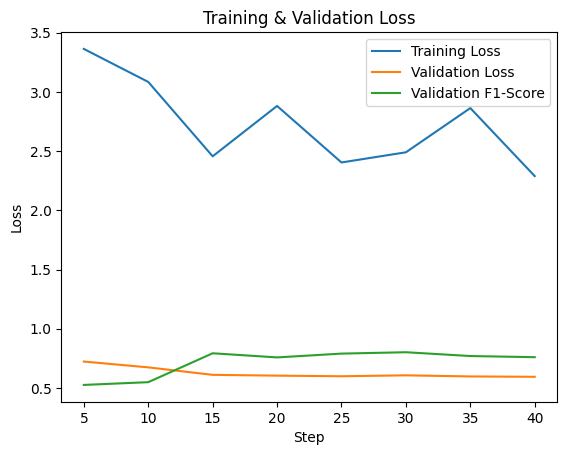

In [ ]:
training_output = trainer.train()

logs_df = pd.DataFrame(trainer.state.log_history)
logs_df

plt.plot(logs_df[logs_df['loss'].notna()].step, logs_df[logs_df['loss'].notna()].loss, label='Training Loss')
plt.plot(logs_df[logs_df['eval_loss'].notna()].step, logs_df[logs_df['eval_loss'].notna()].eval_loss, label='Validation Loss')
plt.plot(logs_df[logs_df['eval_f1'].notna()].step, logs_df[logs_df['eval_f1'].notna()].eval_f1, label = 'Validation F1-Score')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

plt.savefig("riskcomm_learningcurve.png", dpi = 300, bbox_inches = "tight")


In [ ]:
#saving the model

merged_model = tuned_model.merge_and_unload()

save_path = "./qwen3_riskcomm_finetuned_saved"
merged_model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

!zip -r qwen3_riskcomm_finetuned_saved.zip ./qwen3_riskcomm_finetuned_saved
files.download("qwen3_riskcomm_finetuned_saved.zip")

NameError: name 'tuned_model' is not defined

In [ ]:
# Free training memory
del trainer
del train_ds, val_ds
del training_output
torch.cuda.empty_cache()
gc.collect()

print("🧹 Training memory freed. Only base and fine-tuned models remain.")

🧹 Training memory freed. Only base and fine-tuned models remain.


In [ ]:
# loading the fine-tuned model folder from google drive

from google.colab import drive
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/Uni/Master/DLSS_project/qwen3_riskcomm_finetuned_saved.zip"

!unzip /content/drive/MyDrive/Uni/Master/DLSS_project/qwen3_riskcomm_finetuned_saved.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/Uni/Master/DLSS_project/qwen3_riskcomm_finetuned_saved.zip
   creating: qwen3_riskcomm_finetuned_saved/
  inflating: qwen3_riskcomm_finetuned_saved/tokenizer.json  
  inflating: qwen3_riskcomm_finetuned_saved/model.safetensors  
  inflating: qwen3_riskcomm_finetuned_saved/vocab.json  
  inflating: qwen3_riskcomm_finetuned_saved/special_tokens_map.json  
  inflating: qwen3_riskcomm_finetuned_saved/chat_template.jinja  
  inflating: qwen3_riskcomm_finetuned_saved/merges.txt  
  inflating: qwen3_riskcomm_finetuned_saved/added_tokens.json  
  inflating: qwen3_riskcomm_finetuned_saved/config.json  
  inflating: qwen3_riskcomm_finetuned_saved/tokenizer_config.json  


In [ ]:
#loading the model

model_path = "./qwen3_riskcomm_finetuned_saved"

tuned_model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

tuned_model.to(device)

Qwen3ForSequenceClassification(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024, padding_idx=151643)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
     

In [ ]:
#evaluating the tuned model:
acc_lora, conf_lora = evaluate_model(test_loader, tuned_model, device)

Evaluating:   0%|          | 0/75 [00:00<?, ?it/s]

Accuracy: 0.7866666666666666
Classification_report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86        57
           1       0.56      0.56      0.56        18

    accuracy                           0.79        75
   macro avg       0.71      0.71      0.71        75
weighted avg       0.79      0.79      0.79        75

Confusion Matrix:
 [[49  8]
 [ 8 10]]


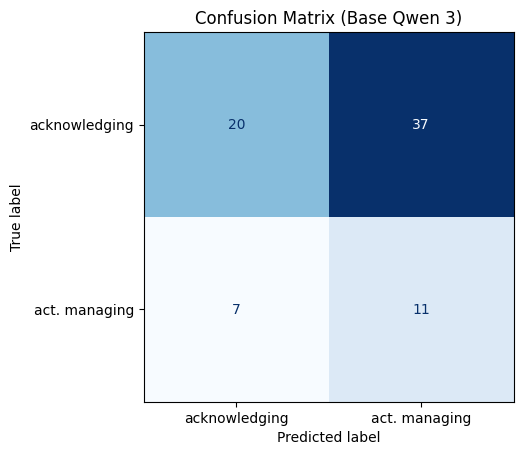

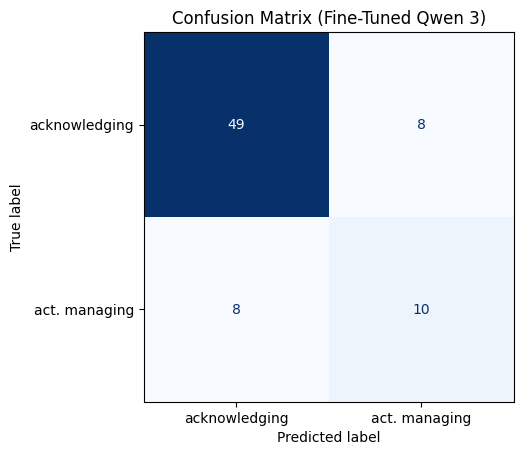

In [ ]:
#confusion matrices

class_labels = ["acknowledging", "act. managing"]
disp_base = ConfusionMatrixDisplay(confusion_matrix = conf_base, display_labels = class_labels)
disp_base.plot(cmap = plt.cm.Blues, values_format = "d", colorbar = False)
plt.title("Confusion Matrix (Base Qwen 3)")
plt.savefig("riscomm_conf_base.png", dpi = 300, bbox_inches = "tight")
plt.show()

disp_tuned = ConfusionMatrixDisplay(confusion_matrix = conf_lora, display_labels = class_labels)
disp_tuned.plot(cmap = plt.cm.Blues, values_format = "d", colorbar = False)
plt.title("Confusion Matrix (Fine-Tuned Qwen 3)")
plt.savefig("riscomm_conf_tuned.png", dpi = 300, bbox_inches = "tight")
plt.show()


# Classifying All Texts

In [ ]:
# classify all texts

for i, row in tqdm(df.iterrows(), desc = "Generating Risk Communication Predictions", total = len(df)):
  prompt = build_prompt(row["full_text"], row["full_sentiment"], tokenizer, max_len)

  inputs = tokenizer(
      prompt,
      return_tensors = "pt",
      truncation = True,
      padding = "max_length",
      max_length = max_len
  )

  inputs = {k: v.to(tuned_model.device) for k,v in inputs.items()}

  tuned_model.eval()

  with torch.no_grad():
    outputs = tuned_model(**inputs)
    logits = outputs.logits

  pred_class = torch.argmax(logits, dim=-1).item()

  df.at[i, "Risk_comm_active"] = pred_class

display(df.head())

df.to_excel("df_envrisk_riskcomm_grouped.xlsx", index = False)


Generating Risk Communication Predictions:   0%|          | 0/2577 [00:00<?, ?it/s]

,cik,FiscalYearEnd,text,sentence_order,dict_label,baseline_label,doc_id,label,sentiment_id,sentiment,full_text,full_sentiment_id,full_sentiment,Risk_comm_active
0,1800,2006-12-31 00:00:00,['· Changes in or interpretations of laws and ...,[77],[0],[0],['1800_2006-12-31'],[1],[2],['Negative'],· Changes in or interpretations of laws and re...,2,Negative,0.0
1,1800,2007-12-31 00:00:00,['Problems may arise during manufacturing for ...,[62],[0],[0],['1800_2007-12-31'],[1],[2],['Negative'],Problems may arise during manufacturing for av...,2,Negative,0.0
2,1800,2020-12-31 00:00:00,['Problems may arise during manufacturing for ...,[35],[0],[0],['1800_2020-12-31'],[1],[2],['Negative'],Problems may arise during manufacturing for av...,2,Negative,0.0
3,1800,2021-12-31 00:00:00,['Problems may arise during manufacturing for ...,[35],[0],[0],['1800_2021-12-31'],[1],[2],['Negative'],Problems may arise during manufacturing for av...,2,Negative,0.0
4,1800,2022-12-31 00:00:00,['Problems may arise during manufacturing for ...,[43],[0],[0],['1800_2022-12-31'],[1],[2],['Negative'],Problems may arise during manufacturing for av...,2,Negative,0.0
